In [10]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt, yaml
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
# import albumentations as A # Library for augmentations
# from albumentations.pytorch import ToTensorV2
import pandas as pd
from PIL import Image
import torch.optim as optim
from torchvision import datasets, models, transforms
import torch.nn as nn
# from torchvision.transforms.functional import Interpolate
import torch.nn.functional as Func
from datetime import datetime
from torchvision.io import read_image
import time
import torch.optim as optim
import copy
from torchvision.models.detection.anchor_utils import DefaultBoxGenerator
from torchvision.models.detection.ssd import SSD, SSDHead, SSDClassificationHead

In [11]:
def load_class_info(yaml_file):
    with open(yaml_file, 'r') as file:
            class_info = yaml.safe_load(file)
    return class_info['classes']
    
def label_transform(classes, labels, num_classes): #One-hot encoding
    class_to_index = {class_name: index for index, class_name in enumerate(classes)}
    target = np.zeros(num_classes, dtype=int)
    for label in labels:
        if label in class_to_index:
            index = class_to_index[label]
            target[index] = 1
    return target
    
def transform(image, keypoints, one_hot_label, num_classes, image_size=(224, 224), fusion='concat'):
    transform_ops = transforms.Compose([
        transforms.Resize(image_size),
    ])
    image = transform_ops(image)
    keypoints = torch.tensor(keypoints).float()
    one_hot_label = torch.tensor(one_hot_label).float()
    one_hot_channel = one_hot_label.unsqueeze(1).unsqueeze(2).expand(len(one_hot_label), image_size[0], image_size[1])
    one_hot_channel = one_hot_channel.sum(dim=0, keepdim=True)
    
    # input_combined = []

    if fusion == 'concat':
        input_combined = torch.cat((image, one_hot_channel), dim=0)
        # print("concat")

    elif fusion == 'add':
        # print("add")
        if image.shape[0] == 3:
            # print("addddd")
            padding = torch.zeros_like(image[0]).unsqueeze(0)
            padded_one_hot_channel = torch.cat([one_hot_channel, padding, padding], dim=0)
        input_combined = image + padded_one_hot_channel

    elif fusion == 'multiply':
        # print("multiply")
        if image.shape[0] == 3:
            # print("multiplyyyyyy")
            one_hot_channel = one_hot_channel.repeat(3, 1, 1)
        input_combined = image * one_hot_channel
        
    if fusion == 'concat':
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.0], std=[0.229, 0.224, 0.225, 1.0])
    else:
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    input_combined = normalize(input_combined)
    
    return input_combined, keypoints

def denormalize_image(image):
    denormalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )
    image = denormalize(image)
    image = torch.clamp(image, 0, 1)
    return image

def visualize_keypoints(image, keypoints):
    image = denormalize_image(image)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=10, marker='.', c='r')
    plt.show()

In [12]:
class ClassDataset(Dataset):
    def __init__(self, dataset_folder, class_info_file, transform=None, label_transform=None, fusion_type='concat'):
        self.dataset_folder = dataset_folder
        self.transform = transform
        self.label_transform = label_transform
        self.imgs_files = self.load_data(dataset_folder)
        self.class_names = load_class_info(class_info_file)
        self.num_classes = len(self.class_names)
        self.fusion_type = fusion_type

    def load_data(self, dataset_folder):
        images_path = os.path.join(self.dataset_folder,"images/")
        annotations_path = os.path.join(self.dataset_folder,"annotations/")
        j_data = []
        for file in os.listdir(images_path):
            if file.endswith(".jpg"):
                json_path = os.path.join(annotations_path, file.split('.')[0] + '.json')
                with open(json_path) as f:
                    json_load = json.load(f)
                    for item in json_load['shapes']:
                        points = [value for row in item['points'] for value in row]
                        j_data.append({'image':  os.path.join(images_path,file),
                                     'label': item['label'],
                                     'points':points })
        json_data = pd.DataFrame(j_data)
        return json_data

    def get_keypoint(self, bboxes):
        centers = []
        for bbox in bboxes:
            center_x = (bbox[0] + bbox[2]) / 2
            center_y = (bbox[1] + bbox[3]) / 2
            centers.append((center_x, center_y))
        return centers
    
    def __len__(self):
        return len(self.imgs_files)

    def __getitem__(self, idx):
        target = {}
        img_path, label, bboxes_original = self.imgs_files.iloc[idx]
        label = [label]
        bboxes_original = [bboxes_original]
        keypoint_original = self.get_keypoint(bboxes_original)
        img_original = read_image(img_path).float() / 255.0

        if self.transform:
            label_transform = self.label_transform(self.class_names,label, self.num_classes)
            img, target['keypoints'] = self.transform(img_original, keypoint_original, label_transform, self.num_classes, fusion=self.fusion_type)
            target['labels'] = torch.as_tensor(label_transform, dtype=torch.int64)
        else:
            # img, bboxes = img_original, bboxes_original
            img, target['keypoints'] = img_original, keypoint_original
            target['labels'] = label

        return img, target, img_original
    

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

# class_config_path = '../config/class.yaml'
class_config_path = '../../config/formated_class.yaml'
DATASET_FOLDER_TRAIN = './../../../../RnD_datasets/robocup_dataset'
# DATASET_FOLDER_TRAIN = '../../dataset/robocup_test_dataset/'
train_path = os.path.join(DATASET_FOLDER_TRAIN,"train/")
val_path = os.path.join(DATASET_FOLDER_TRAIN,"val/")

# fusion_type = 'concat'
fusion_type = 'add'
# fusion_type = 'multiply'

train_dataset = ClassDataset(train_path, class_config_path, transform=transform, label_transform=label_transform, fusion_type=fusion_type)
valid_dataset = ClassDataset(val_path, class_config_path, transform=transform, label_transform=label_transform, fusion_type=fusion_type)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

dataloaders = {'train': train_loader, 'val': valid_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(valid_dataset)}

fusion type:  add
concatenated input size =  torch.Size([3, 224, 224])
keypoint = tensor([[294.5000, 358.0000]])
label = tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])


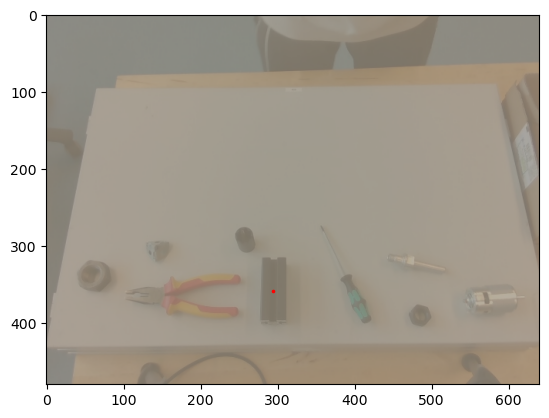

In [15]:
iterator = iter(valid_loader)
images, targets, img = next(iterator)
image_number = 0
num_channels = images[image_number].shape[0]
print("fusion type: ", fusion_type)
print("concatenated input size = ", images[image_number].shape)
print(f"keypoint = {targets[image_number]['keypoints']}\nlabel = {targets[image_number]['labels']}")

visualize_keypoints(img[image_number], targets[image_number]['keypoints'])

In [17]:
# class ConditionalSSD(nn.Module):
#     def __init__(self, num_classes, num_keypoints, input_channels=4):  # Adjust input channels based on fusion method
#         super(ConditionalSSD, self).__init__()
#         self.num_classes = num_classes
#         self.num_keypoints = num_keypoints
#         self.backbone = models.mobilenet_v2(pretrained=True).features
        
#         # self.backbone[0][0] = nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1, bias=False)
#         self.backbone[0] = nn.Sequential(
#             nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(32),
#             nn.ReLU6(inplace=True)
#         )
#         self.anchor_generator = DefaultBoxGenerator(
#             aspect_ratios=[[2.0], [2.0, 3.0], [2.0, 3.0], [2.0, 3.0], [2.0], [2.0]],
#             scales=[0.2, 0.34, 0.48, 0.62, 0.76, 0.9, 1.04],
#             steps=[8, 16, 32, 64, 100, 300]
#         )
#         num_anchors = self.anchor_generator.num_anchors_per_location()
#         # self.feature_maps = [self.backbone[:7], self.backbone[7:14], self.backbone[14:]]
#         # out_channels = [self.backbone[6][0].out_channels, self.backbone[13][0].out_channels, self.backbone[-1][0].out_channels]
#         # out_channels = self.backbone[-1][0].out_channels if isinstance(self.backbone[-1], nn.Sequential) else self.backbone[-1].out_channels
#         self.feature_map_layers = [6, 13, -1]
#         self.out_channels = [self._get_out_channels(self.backbone[i]) for i in self.feature_map_layers]
        
#         self.classification_head = SSDClassificationHead(self.out_channels[-1], num_anchors[-1]*self.num_classes, self.num_classes)
#         self.keypoint_head = nn.Conv2d(in_channels=self.out_channels[-1], out_channels=num_keypoints * 2, kernel_size=3, padding=1)
        
#         self.size = (300, 300)

#     def _get_out_channels(self, layer):
#         if isinstance(layer, nn.Sequential):
#             for sublayer in layer:
#                 if isinstance(sublayer, nn.Conv2d):
#                     return sublayer.out_channels
#         elif isinstance(layer, nn.Conv2d):
#             return layer.out_channels
#         elif isinstance(layer, models.mobilenetv2.InvertedResidual):
#             for sublayer in layer.conv:
#                 if isinstance(sublayer, nn.Conv2d):
#                     out_channels = sublayer.out_channels
#             return out_channels
#         raise ValueError("Unsupported layer type: {}".format(type(layer)))
        
#     def forward(self, x):
#         features = []
#         for i, layer in enumerate(self.backbone):
#             x = layer(x)
#             if i in self.feature_map_layers:
#                 features.append(x)
                
#         keypoint_outputs = self.keypoint_head(features)
#         class_outputs = self.classification_head(features)
        
#         return keypoint_outputs, class_outputs

In [27]:
class ConditionalSSD(nn.Module):
    def __init__(self, num_classes, num_keypoints, input_channels=4):
        super(ConditionalSSD, self).__init__()
        self.num_classes = num_classes
        self.num_keypoints = num_keypoints
        self.backbone = models.mobilenet_v2(pretrained=True).features
        
        # Adjust the first layer to accept the specified number of input channels
        self.backbone[0] = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )
        
        self.anchor_generator = DefaultBoxGenerator(
            aspect_ratios=[[2.0], [2.0, 3.0], [2.0, 3.0], [2.0, 3.0], [2.0], [2.0]],
            scales=[0.2, 0.34, 0.48, 0.62, 0.76, 0.9, 1.04],
            steps=[8, 16, 32, 64, 100, 300]
        )
        num_anchors = self.anchor_generator.num_anchors_per_location()
        self.feature_map_layers = [6, 13, -1]
        self.out_channels = [self._get_out_channels(self.backbone[i]) for i in self.feature_map_layers]
        
        # Pass lists to SSDClassificationHead
        self.classification_head = SSDClassificationHead(self.out_channels, num_anchors, self.num_classes)
        
        # Create multiple keypoint heads for each feature map
        self.keypoint_heads = nn.ModuleList([
            nn.Conv2d(in_channels=out_channel, out_channels=num_keypoints * 2, kernel_size=3, padding=1)
            for out_channel in self.out_channels
        ])
        
        self.size = (300, 300)

    def _get_out_channels(self, layer):
        if isinstance(layer, nn.Sequential):
            for sublayer in layer:
                if isinstance(sublayer, nn.Conv2d):
                    return sublayer.out_channels
        elif isinstance(layer, nn.Conv2d):
            return layer.out_channels
        elif isinstance(layer, models.mobilenetv2.InvertedResidual):
            for sublayer in layer.conv:
                if isinstance(sublayer, nn.Conv2d):
                    out_channels = sublayer.out_channels
            return out_channels
        raise ValueError("Unsupported layer type: {}".format(type(layer)))
        
    def forward(self, x):
        features = []
        for i, layer in enumerate(self.backbone):
            x = layer(x)
            if i in self.feature_map_layers:
                features.append(x)
                
        # Apply keypoint heads to each feature map
        keypoint_outputs = [head(feature) for head, feature in zip(self.keypoint_heads, features)]
        
        # The classification head already handles multiple feature maps
        class_outputs = self.classification_head(features)
        
        return keypoint_outputs, class_outputs

In [28]:
def loss_fn_ssd(loc_preds, loc_targets, cls_preds, cls_targets):
    bbox_loss = nn.MSELoss()(loc_preds, loc_targets)
    class_loss = nn.CrossEntropyLoss()(cls_preds, cls_targets)
    return bbox_loss + class_loss
    
def LaplaceNLLLoss(input, target, scale, eps=1e-06, reduction='mean'):
    loss = torch.log(2*scale) + torch.abs(input - target)/scale

    # Inputs and targets much have same shape
    input = input.view(input.size(0), -1)
    target = target.view(target.size(0), -1)
    if input.size() != target.size():
        raise ValueError("input and target must have same size")

    # Second dim of scale must match that of input or be equal to 1
    scale = scale.view(input.size(0), -1)
    if scale.size(1) != input.size(1) and scale.size(1) != 1:
        raise ValueError("scale is of incorrect size")

    # Check validity of reduction mode
    if reduction != 'none' and reduction != 'mean' and reduction != 'sum':
        raise ValueError(reduction + " is not valid")

    # Entries of var must be non-negative
    if torch.any(scale < 0):
        raise ValueError("scale has negative entry/entries")

    # Clamp for stability
    scale = scale.clone()
    with torch.no_grad():
        scale.clamp_(min=eps)

    # Calculate loss (without constant)
    loss = (torch.log(2*scale) + torch.abs(input - target) / scale).view(input.size(0), -1).sum(dim=1)


    # Apply reduction
    if reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    else:
        return loss
    

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=25):
    since = time.time()
    val_acc_history = []
    train_losses = []
    val_losses = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, targets, img in dataloaders[phase]:
                inputs = torch.stack(inputs).to(device)
                keypoints_ground = torch.stack([target['keypoints'].to(device) for target in targets])
                # print(targets)
                labels_ground = torch.stack([target['labels'].to(device) for target in targets])
                # print(inputs)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    keypoint_outputs, class_outputs = model(inputs)
                    loss = criterion(keypoint_outputs, keypoints_ground, class_outputs, labels_ground)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]

            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                val_acc_history.append(epoch_loss)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_losses, val_losses


def plot_loss(train_loss, val_loss):
    plt.plot(train_loss, label='Training loss')
    plt.plot(val_loss, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plotting function for keypoints
def plot_keypoints(image, keypoints, pred_keypoints, fusion_method):
    image = denormalize_image(image, fusion_method)
    image = transforms.ToPILImage()(image[:3])  # Use only RGB channels for visualization
    plt.imshow(image)
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=10, marker='.', c='r')
    plt.scatter(pred_keypoints[:, 0], pred_keypoints[:, 1], s=10, marker='x', c='b')
    plt.show()




concatenated input size =  torch.Size([3, 224, 224])
keypoint = tensor([[298.5000, 384.5000]])
label = tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])


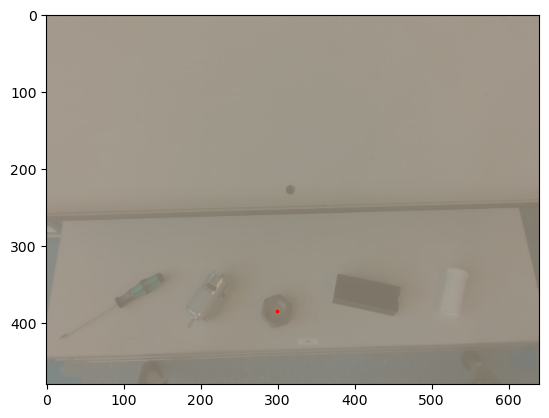

In [30]:
iterator = iter(valid_loader)
combined_input, targets, img = next(iterator)
image_number = 0

print("concatenated input size = ", combined_input[image_number].shape)
print(f"keypoint = {targets[image_number]['keypoints']}\nlabel = {targets[image_number]['labels']}")

visualize_keypoints(img[image_number], targets[image_number]['keypoints'])

In [31]:
num_channels = combined_input[image_number].shape[0]
num_classes = len(load_class_info(class_config_path))
num_keypoints = 1
model = ConditionalSSD(num_classes=num_classes, num_keypoints=num_keypoints, input_channels=num_channels)
model = model.to(device)
criterion = loss_fn_ssd
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train and validate the model
model, val_acc_history, train_losses, val_losses = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=100)

torch.save(model.state_dict(), './models/complete_dataset/ssd_conditional_'+fusion_type+'_2.pth')

# train_losses, valid_losses = train_model(model, criterion, criterion_kpt, optimizer, train_loader, valid_loader, num_epochs=80)
# trained_model, train_loss, key_train_loss, val_loss, key_val_loss = train_model(model, criterion_cls, criterion_kpt, optimizer, train_loader, valid_loader, num_epochs=50)
# train_model(model, criterion, optimizer, num_epochs)
# torch.save(model.state_dict(), '../models/ssd/ssd_trained_1.pth')

Epoch 0/99
----------


AttributeError: 'list' object has no attribute 'size'

In [ ]:
# Plot training and validation loss
plot_loss(train_losses, val_losses)

# Inference and visualization
model.eval()
inputs, keypoints = next(iter(val_loader))
inputs = inputs.to(device)
outputs = model(inputs)

for i in range(inputs.size(0)):
    visualize_keypoints(inputs[i][:3], keypoints[i])  # Use only RGB channels for visualization
    plot_keypoints(inputs[i][:3], keypoints[i], outputs[i].cpu().detach().numpy())

In [15]:
# def plot_losses(train_losses, valid_losses):
#     plt.figure(figsize=(10, 6))
#     plt.plot(train_losses, label='Training Loss')
#     plt.plot(valid_losses, label='Validation Loss')
#     plt.title('Training and Validation Loss Over 100 Epochs')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# plot_losses(train_loss, val_loss)

In [16]:
# num_classes = 4 
# model = CustomResNet50(num_classes=num_classes, num_keypoints=1)

# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# print('device = ', device)
# model.to(device)

# # criterion = RnDLossFunction() 
# criterion = nn.CrossEntropyLoss()
# criterion_kpt = torch.nn.MSELoss()

# optimizer = optim.Adam(model.parameters(), lr=0.001)

# num_epochs = 50
# temp = None


In [17]:
# def train_model(model, criterion, criterion_kpt, optimizer, train_loader, valid_loader, num_epochs=25):
#     train_losses = []
#     valid_losses = []
#     alpha = torch.full((5, 2), 0.1)  # Moderate confidence
#     beta = torch.full((5, 2), 2.0)

#     for epoch in range(num_epochs):
#         model.train()
#         total_train_loss = 0.0
#         total_kpt_loss = 0.0

#         for images, targets, concat_vecs, labels in train_loader:
            
#             labels = [label.to(device) for label in labels]
#             concat_vecs = torch.stack(concat_vecs).to(device)
#             ground_truth_keypoints = torch.stack([target['keypoints'].to(device) for target in targets])

#             optimizer.zero_grad()
            
#             class_outputs, keypoint_outputs = model(concat_vecs)
#             labels_tensor = torch.stack(labels)
#             class_indices = torch.argmax(labels_tensor, dim=1)
#             ls = torch.argmax(class_outputs, dim=1)
#             print('ls = ', ls)
#             print('class_outputs = ', class_outputs)
#             print('class_indices = ', class_indices)
#             print('labels = ', labels)
#             print('keypoint_outputs = ', keypoint_outputs)
#             print('ground_truth_keypoints = ', ground_truth_keypoints)

#             # optimizer_kpt = optim.SGD([keypoint_outputs], lr=0.01)  # Replace [keypoints_outputs] with model.parameters() if keypoints_outputs are model outputs
#             # optimizer_kpt.zero_grad()

#             loss = criterion(class_outputs, class_indices)
#             # loss_kpt = GeneralGaussianNLLLoss(keypoint_outputs, ground_truth_keypoints, alpha=alpha, beta=beta, eps=1e-06, reduction='mean')
#             loss_kpt = criterion_kpt(keypoint_outputs, ground_truth_keypoints)
#             loss.backward()
#             loss_kpt.backward()
#             optimizer.step()
#             # optimizer_kpt.step()
#             total_train_loss += loss.item() * concat_vecs.size(0)
#             total_kpt_loss += loss_kpt.item() * concat_vecs.size(0)
        
#         train_epoch_loss = total_train_loss / len(train_loader.dataset)
#         train_kpt_loss = total_kpt_loss / len(valid_loader.dataset)

#         train_losses.append(train_epoch_loss)
#         print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_epoch_loss}, Train Keypoint Loss: {train_kpt_loss}')
        

#         model.eval()
#         total_val_loss = 0.0
#         total_kpt_loss_val = 0.0

#         with torch.no_grad():
#             for images, targets, concat_vecs, labels in valid_loader:
#                 concat_vecs = torch.stack(concat_vecs).to(device)
#                 labels = torch.stack([label.to(device) for label in labels])
#                 ground_truth_keypoints_val = torch.stack([target['keypoints'].to(device) for target in targets])

#                 class_outputs, keypoint_outputs = model(concat_vecs)
#                 labels_tuple = tuple(labels[i] for i in range(labels.size(0)))
#                 labels_tensor = torch.stack(labels_tuple)
#                 class_indices = torch.argmax(labels_tensor, dim=1)
                
#                 loss = criterion(class_outputs, class_indices)  
#                 loss_kpt_val = GeneralGaussianNLLLoss(keypoint_outputs, ground_truth_keypoints_val,alpha=alpha, beta=beta, eps=1e-06, reduction='mean')

#                 total_val_loss += loss.item() * concat_vecs.size(0)
#                 total_kpt_loss_val += loss_kpt_val.item() * concat_vecs.size(0)

#         avg_valid_loss = total_val_loss / len(valid_loader.dataset)
#         val_kpt_loss = total_kpt_loss_val / len(valid_loader.dataset)
#         valid_losses.append(avg_valid_loss)
        
#         print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_valid_loss}, Val Keypoint Loss: {val_kpt_loss}')
    
#     return train_losses, valid_losses




In [18]:
# timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# train_losses, valid_losses = train_model(model, criterion, criterion_kpt, optimizer, train_loader, valid_loader, num_epochs=80)
# # train_model(model, criterion, optimizer, num_epochs)
# torch.save(model.state_dict(), '../models/resnet50_trained_11.pth')

In [19]:
# def plot_losses(train_losses, valid_losses):
#     plt.figure(figsize=(10, 6))
#     plt.plot(train_losses, label='Training Loss')
#     plt.plot(valid_losses, label='Validation Loss')
#     plt.title('Training and Validation Loss Over 100 Epochs')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# plot_losses(train_losses, valid_losses)

In [20]:
# model.load_state_dict(torch.load('../models/resnet50_trained_11.pth'))
# model.eval()

# def val_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=25):
#     valid_losses = []
#     total_val_loss = 0.0
#     image = []
#     keypoint = []

#     with torch.no_grad():
#         for images, targets, concat_vecs, labels in valid_loader:
#             concat_vecs = torch.stack(concat_vecs).to(device)
#             labels = torch.stack([label.to(device) for label in labels])
#             ground_truth_keypoints_val = torch.stack([target['keypoints'].to(device) for target in targets])

#             print('ground_truth_keypoints_val = ', ground_truth_keypoints_val)
#             class_outputs, keypoint_outputs = model(concat_vecs)
#             _, predicted = torch.max(class_outputs, 1)
#             print('targets = ', targets[0]['keypoints'])
#             # print('class_outputs = ', class_outputs)
#             print('predicted = ', predicted)
#             print('keypoint_outputs = ', keypoint_outputs)
#             print('labels = ', labels)
#             labels_tuple = tuple(labels[i] for i in range(labels.size(0)))
#             labels_tensor = torch.stack(labels_tuple)
#             class_indices = torch.argmax(labels_tensor, dim=1)
            
#             image.append(images)
#             keypoint.append(keypoint_outputs)
#             loss = criterion(class_outputs, class_indices)
#             total_val_loss += loss.item() * concat_vecs.size(0)
            
#     avg_valid_loss = total_val_loss / len(valid_loader.dataset)
    
#     valid_losses.append(avg_valid_loss)
#     return image, keypoint


In [21]:
# images_val, keypoints_val = val_model(model, criterion_cls, optimizer, train_loader, valid_loader, num_epochs=75)
# print('images_val = ', images_val[0][0].shape)
# # val_accuracy = val_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=75)


In [22]:
# img_size = 84
# kp = keypoints_val[0].reshape(-1, 2)
# print(np.array(kp))
# print(np.array(kp[0]))

# denormalized_keypoints = ((kp[0] + 1) * img_size)
# # denormalized_keypoints = [52, 40]
# print(denormalized_keypoints)

# dky = np.array(dk(kp[0],84,84))
# print("model key",dky[0])
# pic = (images_val[0][0].permute(1,2,0).detach().numpy() * 255).astype(np.uint8)
# print(pic.shape)
# fig, ax = plt.subplots()
# # dky = [0.5058, 0.3840]
# ax.imshow(pic)

# # ax.plot(denormalized_keypoints[0], denormalized_keypoints[1], 'ro') 
# ax.plot(dky[0][0], dky[0][1], 'ro')
# # ax.plot(0.5058, 0.3840, 'bo')

# plt.show()


In [23]:
# model.load_state_dict(torch.load('../models/resnet50_trained_3.pth'))
# model.eval()

# # Function to evaluate the model on validation and test sets
# def evaluate_model(model, data_loader):
#     correct = total = 0
#     with torch.no_grad():
#         for inputs, targets, concat_vecs, labels in data_loader:
#             concat_vecs, labels = torch.stack(concat_vecs).to(device), [label.to(device) for label in labels]
#             outputs = model(concat_vecs)
#             _, predicted = torch.max(outputs, 1)
#             print(np.array(labels).shape[0])
#             total += np.array(labels).shape[0]
#             correct_pred = (predicted == labels)
#             print(predicted)
#             total_correct = correct_pred.sum().item()
#             correct += total_correct
#     return 100 * correct / total

In [24]:
# val_accuracy = evaluate_model(model, valid_loader)
# # test_accuracy = evaluate_model(model, test_loader)

# print(f'Validation Accuracy: {val_accuracy:.2f}%')

In [25]:
# def visualize(image, bboxes, image_original=None, bboxes_original=None):
#     fontsize = 18

#     for bbox in bboxes:
#         # for keypoints
#         keypoint = (bbox[0], bbox[1])
#         image = cv2.circle(image.copy(), keypoint, 1, (0,255,0), 2)
#         # for bbox
#         # start_point, end_point = (bbox[0], bbox[1]), (bbox[2], bbox[3])
#         # image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)


#     if image_original is None:
#         plt.figure(figsize=(40,40))
#         plt.imshow(image)

#     else:
#         for bbox in bboxes_original:
#             # for keypoints
#             keypoint = (bbox[0], bbox[1])
#             image_original = cv2.circle(image_original.copy(), keypoint, 1, (0,255,0), 2)
#             # for bbox
#             # start_point, end_point = (bbox[0], bbox[1]), (bbox[2], bbox[3])
#             # image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)


#         f, ax = plt.subplots(1, 2, figsize=(40, 20))

#         ax[0].imshow(image_original)
#         ax[0].set_title('Original image', fontsize=fontsize)

#         ax[1].imshow(image)
#         ax[1].set_title('Transformed image', fontsize=fontsize)

# image1 = (img[image_number].permute(1,2,0).detach().numpy() * 255).astype(np.uint8)
# image = (images[image_number].permute(1,2,0).detach().numpy() * 255).astype(np.uint8)

# print('labels',labels[image_number]['keypoints'])

# # keypoints = labels[image_number]['keypoints'].detach().cpu().numpy().astype(np.float32).tolist()
# keypoints = labels[image_number]['keypoints']
# keypo = keyp[image_number].detach().cpu().numpy().astype(np.int32).tolist()

# print ('keypoints',keypoints)
# print ('image shape',image.shape)

# keypoints = denormalize_keypoints(keypoints, image.shape[0], image.shape[1])
# print ('denormalized',keypoints)
# kp = [[int(t.item()) for t in sublist] for sublist in keypoints]
# print ('kp',kp)

# # visualize(image, bboxes, image, bboxes)
# visualize(image, kp, image, kp)
# print(keypo)
# visualize(image1, keypo, image1, keypo)